In [1]:
import matplotlib.pyplot as plt
import os, sys


from numpy import arange, array, cumsum, nan
from pandas import read_csv, DataFrame
from numpy import zeros, median
from obspy import UTCDateTime
from numpy import isnan
from obspy import UTCDateTime

In [2]:
year = '2021'

mode = 'runy'

channels  = ['BJZ', 'BJU', 'BJV', 'BJW']

path = f'/home/andbro/Documents/ROMY/QualityCheck/{mode}/logs/'

In [3]:
df = []
for cha in channels:
    
    ifile = f'{year}_{cha}_overview'
    ## read data
    try:
        data = read_csv(path+ifile, delimiter=",")
        
        ## sort data frame in case any mixup occured
        data = data.sort_values(by=['doy'], ascending=True, axis=0)

        ## check for doubles 
        doubles = 0
        if data.doy.duplicated().any():
            doubles +=1
        if doubles != 0:
            print(f"\n {doubles} doubles found")
    
    except:
        data = DataFrame()


    df.append(data)


In [4]:
max_samples_per_day = max(df[0].total_samples)
max_days_of_year = UTCDateTime(f"{year}-12-31").julday


stat = DataFrame()

q0p, q1p, q2p = [], [], []
gaps_all = []
no_data = []

dummy = 0.0

for i, data in enumerate(df):
    print(type(data))
#     if str(type(data)) ==  "<class 'list'>":
#         break
    try:

        ##__________________________________
        ##
        
        q0p.append(sum(data.Q0)/sum(data.total_samples)*100)
        q1p.append(sum(data.Q1)/sum(data.total_samples)*100)
        q2p.append(sum(data.Q2)/sum(data.total_samples)*100)

        ##__________________________________
        ##
        
        gaps = []
        for i in range(1, UTCDateTime(f"{year}-12-31").julday):
            if i not in list(data.doy):
                gaps.append(i)     
        gaps_all.append(len(gaps)/ max_days_of_year *100)
    
        ##__________________________________
        ##
        log_no_data = f"{path}{year}-{cha}.log"
        
        doy=[]
        if os.path.isfile(f"{path}{year}-{cha}.log"):

            df_tmp = read_csv(log_no_data, header=0, names =["Date", "Channel", "Comment"])

            doy = []
            for i in df_tmp.Date.to_list():
                doy.append(UTCDateTime(i).julday)

            no_data.append(len(doy)/ max_days_of_year *100)    

        else:
            no_data.append(dummy)
            
    except:
    
        q0p.append(dummy)
        q1p.append(dummy)
        q2p.append(dummy)
    
        gaps_all.append(dummy)
    
        no_data.append(dummy)
        
        
stat['channel'] = channels    
stat['Q0'] = q0p
stat['Q1'] = q1p
stat['Q2'] = q2p
stat['gaps'] = gaps_all 
stat['no_data'] = no_data 


stat

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


,channel,Q0,Q1,Q2,gaps,no_data
0,BJZ,0.020015,0.000000,99.979985,85.205479,4.109589
1,BJU,0.000000,0.000000,100.000000,85.205479,4.109589
2,BJV,0.029282,0.001331,99.969387,85.205479,4.109589
3,BJW,0.000000,0.000000,100.000000,85.205479,4.109589


# Plot Statistics Overview

In [5]:

def autolabel(rects, col):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 7),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    color=col,
                    bbox=dict(ec="w", fc="w"),
                   )


Text(0.5, 1.0, 'Statistics 2021')

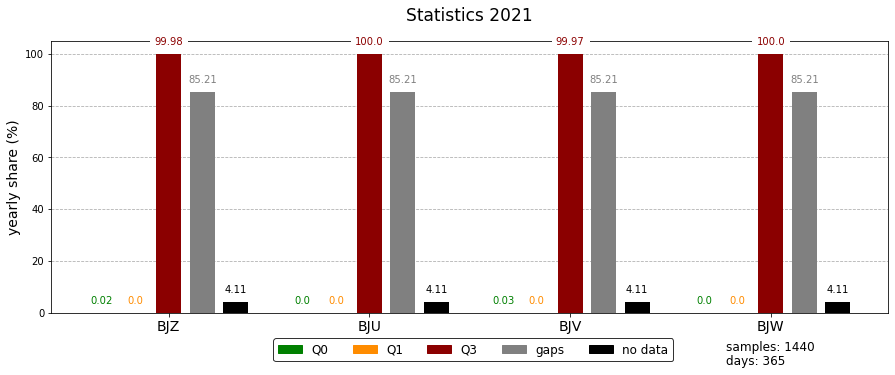

In [6]:
# import seaborn as sns
# sns.set()

fig, ax =  plt.subplots(1, 1, figsize=(15,5))

font=14

bar_width = 0.5

cols = ['green', 'darkorange', 'darkred', 'grey', 'black']
labels = []
locations=[]
ticks = [1,5,9,13]
for x in ticks:
    locations.append([x-4/3, x-2/3, x, x+2/3, x+4/3])

hands = []
for j in range(5):
    b1 = ax.bar(locations[0][j], stat.iloc[0][int(1+j)], width=bar_width, color=cols[j], zorder=2)
    b2 = ax.bar(locations[1][j], stat.iloc[1][int(1+j)], width=bar_width, color=cols[j], zorder=2)
    b3 = ax.bar(locations[2][j], stat.iloc[2][int(1+j)], width=bar_width, color=cols[j], zorder=2)
    b4 = ax.bar(locations[3][j], stat.iloc[3][int(1+j)], width=bar_width, color=cols[j], zorder=2)
    autolabel(b1, cols[j])
    autolabel(b2, cols[j])
    autolabel(b3, cols[j])  
    autolabel(b4, cols[j])  

    
from matplotlib.patches import Polygon, Patch

ax.set_xticks(ticks)
ax.set_xticklabels(channels, fontsize=font)

legend_elements = [Patch(facecolor=cols[0], edgecolor=cols[0], label='Q0'),
                   Patch(facecolor=cols[1], edgecolor=cols[1], label='Q1'),
                   Patch(facecolor=cols[2], edgecolor=cols[2], label='Q3'),
                   Patch(facecolor=cols[3], edgecolor=cols[3], label='gaps'),
                   Patch(facecolor=cols[4], edgecolor=cols[4], label='no data'),
                  ]

ax.legend(handles=legend_elements, 
          loc='lower right', 
          fontsize=font-2, 
          ncol=6, 
          edgecolor='black',
          bbox_to_anchor=(.75,-0.2),
         )

fig.text(0.75, -0.02,  
         f'days: {max_days_of_year}',   
         fontsize = 12, 
         color = "black",
        ) 
fig.text(0.75, 0.02,  
         f'samples: {max_samples_per_day}',   
         fontsize = 12, 
         color = "black",
        ) 

ax.grid(axis="y", zorder=1, ls='--')

ax.set_ylabel("yearly share (%)", fontsize=font)

ax.set_title(f"Statistics {year}", fontsize=font+3, pad=20)